In [2]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [16]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = abs(np.random.randn(n_train,n))+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

False


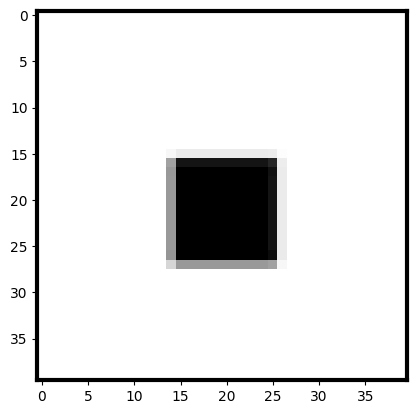

In [4]:
#will not work with mixed state probabilities
from PIL import Image
scale = 40
img = Image.open('images.png')
img_greyscale = img.convert("L")
img_resized = img_greyscale.resize((scale, scale))

img_array = np.array(img_resized, ndmin = 2)
img_resized.save('dog_resized_greyscale.jpg')

collapsed_array = np.zeros(img_array.size)

for i in range(0, img_array.size):
    collapsed_array[i] = img_array[int(i/scale)][i%scale]

test_data = np.zeros((int(img_array.size / 4), 4)) + 1j * np.zeros((int(img_array.size / 4), 4))
temp_normalize = max(collapsed_array) * 4
for i in range(0, int(img_array.size / 4)):
    test_data[i] = collapsed_array[4*i : 4*i+4] / temp_normalize + 1j * np.zeros(4)

plt.imshow(img_array, cmap='grey',interpolation = 'nearest')

# Find where NaN values are
print(np.isnan(test_data).any())

# Get the indices of the NaN values
#nan_indices = np.where(img_array)

#print(nan_indices)

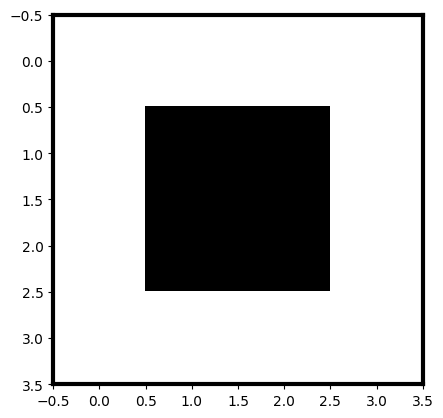

In [18]:
temp_test = np.array([[1, 1, 1, 1], [1, 0, 0, 1], [1, 0, 0, 1], [1, 1, 1, 1]])
plt.imshow(temp_test, cmap='grey',interpolation = 'nearest')
temp_test = temp_test.flatten()


In [19]:
#generate training data for diffusion
n = 4
T = 20
Ndata = 2000

diff_hs = torch.from_numpy(np.linspace(0.5, 4., T))

model_diff = DiffusionModel(n, T, Ndata)

X = torch.from_numpy(generate_training(temp_test, Ndata, 0.05))

np.save('training_data', np.array(X))

(2000, 16)
(16,)


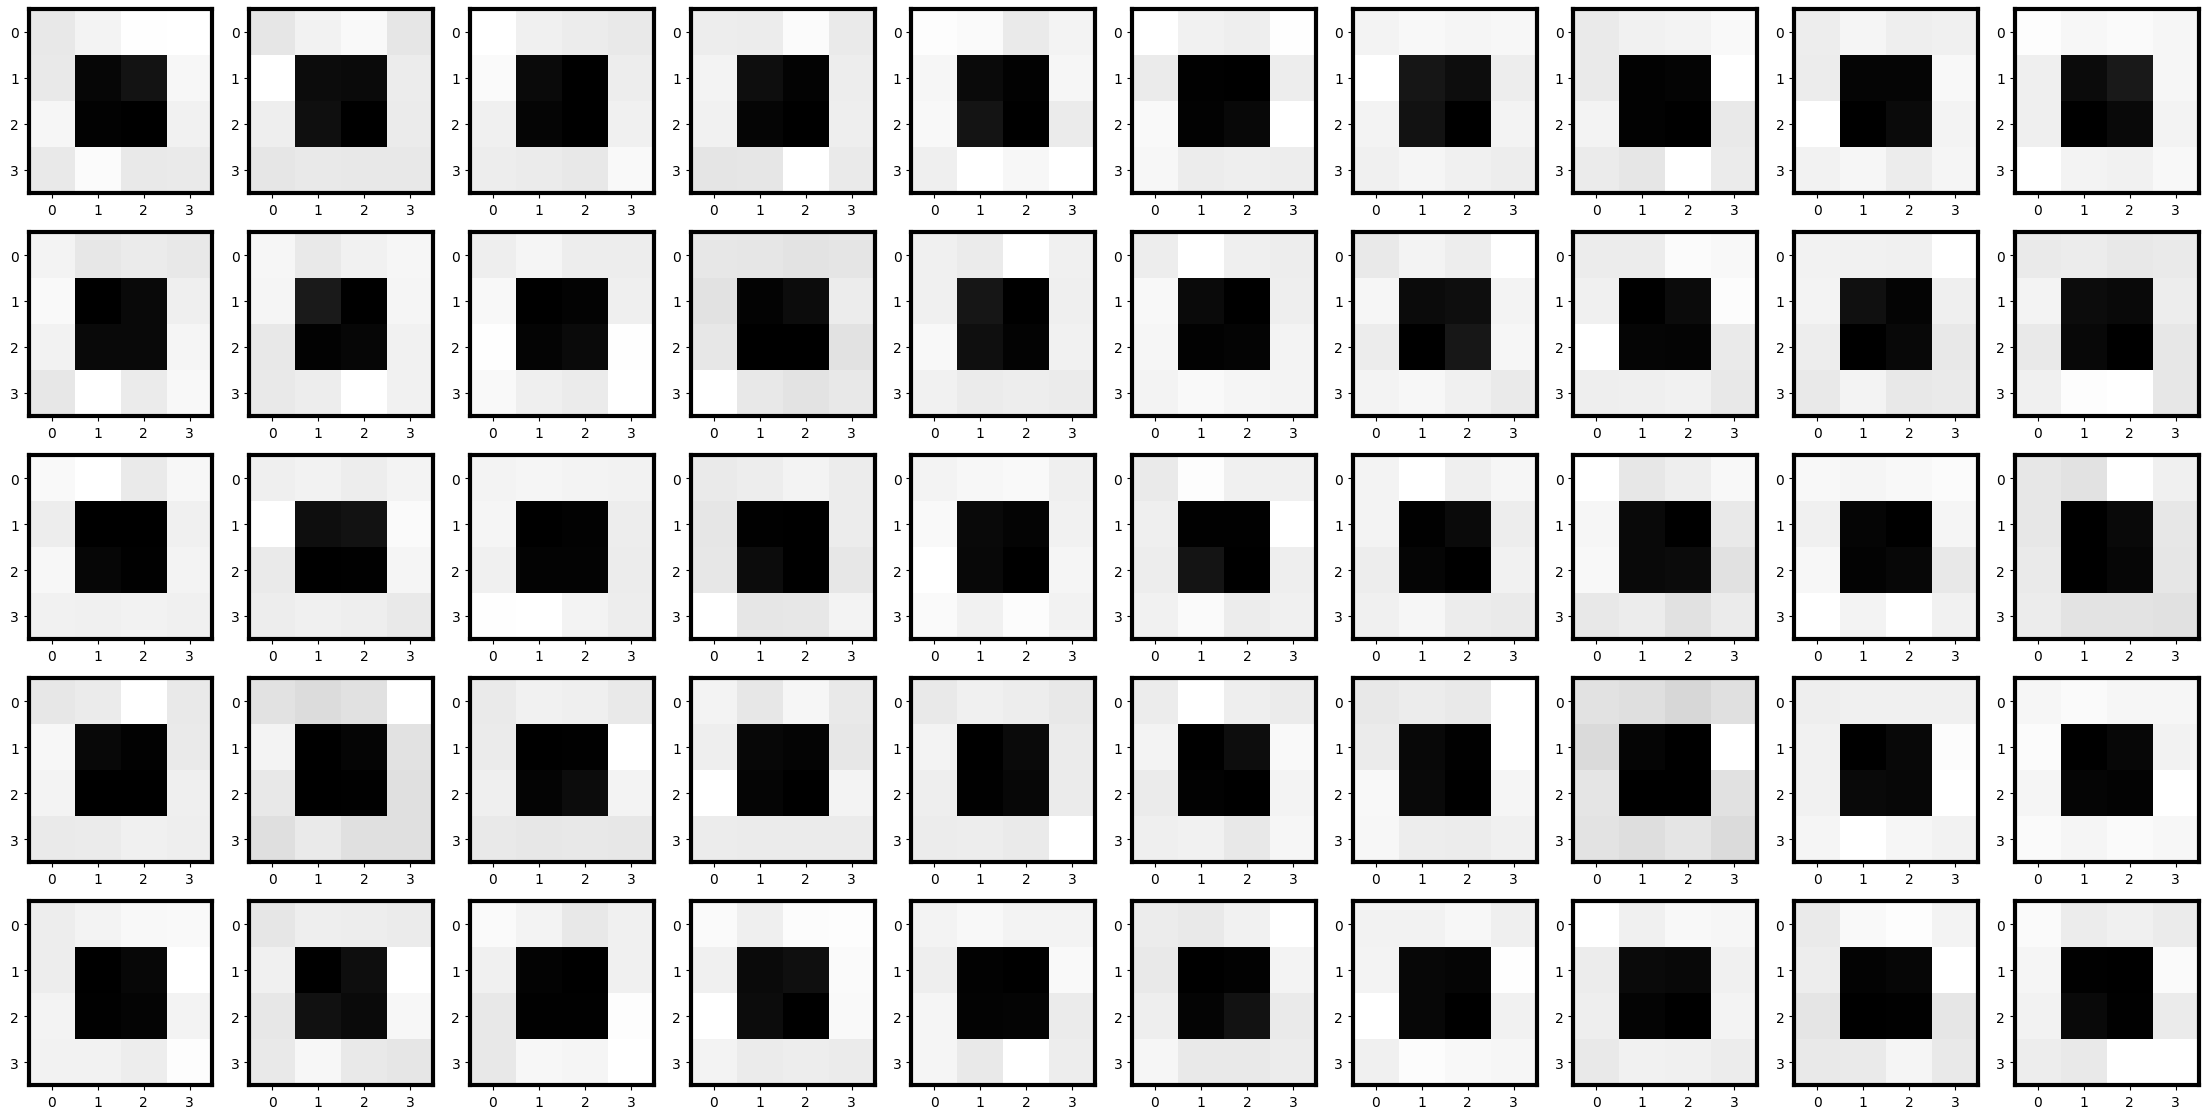

In [11]:
#visualize training data before they are forward diffused
training_temp = np.abs(np.array(X))
multiplier = np.max(training_temp)
training_temp /= multiplier
fig, axs = plt.subplots(5, 10, figsize = (28, 14))
for index_1 in range(0, 50):
    training_images = training_temp[index_1]

    picture_training  = np.zeros((4, 4))
    for i in range(0, 4):
        for j in range(0, 4):
            picture_training[i][j] = training_images[i*4 + j]

    axs[int(index_1 / 10)][index_1 % 10].imshow(picture_training, cmap='grey',interpolation = 'nearest')

In [12]:
#diffuse training data
Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X.numpy()

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

np.save("states_diff", Xout)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [13]:
from scipy.linalg import sqrtm

states_diff = np.load('states_diff.npy')

fidelity = np.zeros((T + 1, Ndata))
for i in range(0, T + 1):
    for j in range(0, Ndata):
        #different calculations for mixed state fidelity
        fidelity[i][j] = np.abs(np.vdot(states_diff[i][j], states_diff[0][j])) ** 2


fidelity_mean = np.mean(fidelity, axis = 1)
print(fidelity)

[[1.         1.         1.         ... 1.         0.99999988 1.        ]
 [0.95379411 0.94283223 0.95989051 ... 0.96230815 0.93162313 0.94562588]
 [0.93342679 0.94968429 0.80878709 ... 0.84761103 0.76824997 0.73139394]
 ...
 [0.03011609 0.10262213 0.04946043 ... 0.09197472 0.0871414  0.150233  ]
 [0.05082321 0.06157269 0.08411071 ... 0.16418842 0.0980667  0.00735945]
 [0.08787546 0.0059782  0.01721599 ... 0.04829054 0.00670319 0.0607175 ]]


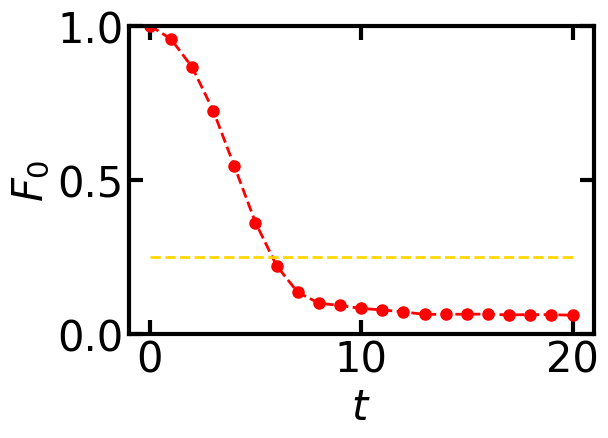

In [14]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 600
states_diff = np.load('states_diff.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(Ndata)

ax.plot(range(T+1), fidelity_mean, 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

In [2]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [3]:
#train on diffusion data
n, na = 4, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 2000 # number of data in the training data set
epochs = 20001

 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = np.load('states_diff.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, T):
        print(tt)
        params_tot[tt] = np.load('paramsandloss_squaremodel/params_t%d.npy'%tt)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('paramsandloss_squaremodel/params_t%d'%t, params.detach().numpy())
    np.save('paramsandloss_squaremodel/loss_t%d'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.0207, grad_fn=<SubBackward0>), time elapsed: 0.08776545524597168 seconds
Step 100, loss: tensor(0.0143, grad_fn=<SubBackward0>), time elapsed: 5.974656581878662 seconds
Step 200, loss: tensor(0.0096, grad_fn=<SubBackward0>), time elapsed: 11.656195878982544 seconds
Step 300, loss: tensor(0.0064, grad_fn=<SubBackward0>), time elapsed: 17.42595076560974 seconds
Step 400, loss: tensor(0.0042, grad_fn=<SubBackward0>), time elapsed: 23.094358682632446 seconds
Step 500, loss: tensor(0.0026, grad_fn=<SubBackward0>), time elapsed: 28.875133991241455 seconds
Step 600, loss: tensor(0.0020, grad_fn=<SubBackward0>), time elapsed: 34.505762815475464 seconds
Step 700, loss: tensor(0.0014, grad_fn=<SubBackward0>), time elapsed: 40.16259956359863 seconds
Step 800, loss: tensor(0.0013, grad_fn=<SubBackward0>), time elapsed: 45.904818058013916 seconds
Step 900, loss: tensor(0.0011, grad_fn=<SubBackward0>), time elapsed: 51.573132038116455 seconds
Step 1000, loss: tensor(0.0010, gr

In [109]:
#train on diffusion data
n, na = 4, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 1000 # number of data in the training data set
epochs = 12001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = np.load('states_diff.npy')

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.load('params_total.npy')
    for tt in range(t+1, T):
        print(tt)
        params_tot[tt] = np.load('paramsandloss_squaremodel/params_t%d.npy'%tt)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('paramsandloss_squaremodel/params_t%d'%t, params.detach().numpy())
    np.save('paramsandloss_squaremodel/loss_t%d'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)

Step 0, loss: tensor(0.0262, grad_fn=<SubBackward0>), time elapsed: 0.03679513931274414 seconds
Step 100, loss: tensor(0.0215, grad_fn=<SubBackward0>), time elapsed: 3.812459945678711 seconds
Step 200, loss: tensor(0.0161, grad_fn=<SubBackward0>), time elapsed: 7.346958875656128 seconds
Step 300, loss: tensor(0.0118, grad_fn=<SubBackward0>), time elapsed: 10.86698293685913 seconds
Step 400, loss: tensor(0.0082, grad_fn=<SubBackward0>), time elapsed: 14.589691400527954 seconds
Step 500, loss: tensor(0.0059, grad_fn=<SubBackward0>), time elapsed: 18.12534761428833 seconds
Step 600, loss: tensor(0.0042, grad_fn=<SubBackward0>), time elapsed: 21.64742136001587 seconds
Step 700, loss: tensor(0.0031, grad_fn=<SubBackward0>), time elapsed: 25.405336618423462 seconds
Step 800, loss: tensor(0.0027, grad_fn=<SubBackward0>), time elapsed: 28.938697338104248 seconds
Step 900, loss: tensor(0.0023, grad_fn=<SubBackward0>), time elapsed: 32.47132849693298 seconds
Step 1000, loss: tensor(0.0020, grad_

In [6]:
n, na = 4, 1
T = 20
L = 6
Ndata = 2000
epochs = 20000 + 1

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('paramsandloss_squaremodel/params_t%d.npy'%t)
    loss_tot[t] = np.load('paramsandloss_squaremodel/loss_t%d.npy'%t)
    

np.save("params_total_2000Ndata_20kEpochs", params_tot)
np.save("loss_tot_2000Ndata_20kEpochs", loss_tot)                            

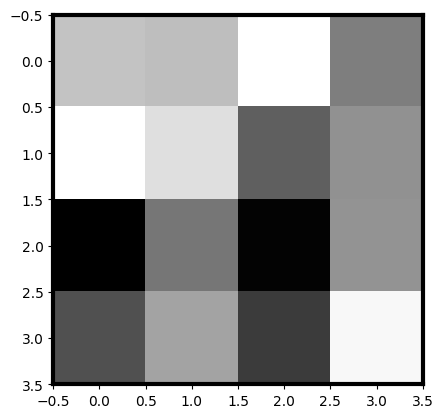

In [4]:
#create random 16 pixel data
Ndata = 50
n = 4
random_images = np.zeros((Ndata, 4, 4))
amplitude_vals = np.zeros(Ndata)

for i in range(0, Ndata):
    random_images[i] = np.random.rand(4,4)
    amplitude_vals[i] = np.sum(random_images[i] ** 2) ** 0.5

plt.imshow(random_images[1], cmap = 'grey', interpolation = 'nearest')

In [5]:
#Turn image data into qubits
random_images_qubits = np.zeros((Ndata, 2**n)) + 1j * np.zeros((Ndata, 2**n))
for i in range(0, Ndata):
    random_images_qubits[i] = np.ravel(random_images[i] / amplitude_vals[i] + 0j)

#print(random_images_qubits)

In [85]:
#Diffuse our test image
n = 4
T = 20
Ndata = 50

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)

diffuse_square = np.zeros((Ndata, 2**n)) + 1j * np.zeros((Ndata, 2**n))
for i in range(0, Ndata):
    diffuse_square[i] = np.array(temp_test / (12**0.5)) + 1j * np.zeros(2**n)

X = torch.from_numpy(diffuse_square)
#X = torch.from_numpy(random_images_qubits)

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

np.save("Xout_testimage", Xout)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [6]:
#use model to predict what original image was from diffused image
diffused_images = np.load('Xout_testimage.npy')
test_data_T20 = torch.tensor(diffused_images[20], dtype = torch.complex64)
#print(Xout[0])
n, na = 4, 1
T = 20
L = 6
Ndata = 50

params_tot = np.load('params_total_2000Ndata_20kEpochs.npy')

diffModel = DiffusionModel(n, T, Ndata)
inputs_te = diffModel.HaarSampleGeneration(Ndata, seed=22)

model = QDDPM(n=n, na=na, T=T, L=L)


#data_te = model.backDataGeneration(test_data_T20, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(torch.from_numpy(random_images_qubits), params_tot, Ndata)[:, :, :2**n].numpy()

np.save("test_backwardsgen", data_te)

In [7]:
backwards_gen = np.load('test_backwardsgen.npy')
print(np.ndim(backwards_gen))

3


In [8]:
#from backwards_gen get the nxn array for the image
backwards_gen = np.load('test_backwardsgen.npy')
dim = 4#int((final_output_flattened.size) ** 0.5)
final_output_nxn = np.zeros((T + 1, Ndata, dim, dim))

for z in range(0, 21):
    final_output_flattened = backwards_gen[z]
    final_output_flattened = np.abs(final_output_flattened)
    multiplier = np.max(final_output_flattened)
    for i in range(0, np.size(amplitude_vals)):
        final_output_flattened[:][i] *= amplitude_vals[i]
    #final_output_flattened = final_output_flattened.flatten()

    for i in range(0, dim):
        for j in range(0, dim):
            for nth_data in range(0, Ndata):
                final_output_nxn[z][nth_data][i][j] = final_output_flattened[nth_data][(i*dim) + j]


In [9]:
print(final_output_nxn[20])

[[[0.37881529 0.9924829  0.36502409 0.56354952]
  [0.98291945 0.00184423 0.54083985 0.43845654]
  [0.24158737 0.39088732 0.26326311 0.05454385]
  [0.72323108 0.09985524 0.9247148  0.93785793]]

 [[0.77530569 0.75433999 0.99660558 0.51560795]
  [0.9976033  0.87785959 0.40256074 0.58681762]
  [0.04788043 0.48599678 0.06118194 0.59382915]
  [0.34558684 0.65512115 0.2689738  0.97009063]]

 [[0.32765019 0.00206653 0.6361618  0.7916128 ]
  [0.39878047 0.72215533 0.76918352 0.93433154]
  [0.26971069 0.18723755 0.83239204 0.98767221]
  [0.07457087 0.06002143 0.69135612 0.61806995]]

 [[0.70742476 0.36684838 0.52213907 0.27367702]
  [0.43233776 0.53962862 0.90716076 0.85649383]
  [0.25310919 0.50950313 0.9356643  0.15290259]
  [0.3181062  0.91900724 0.91043442 0.84843618]]

 [[0.91217428 0.40718284 0.04979086 0.24673502]
  [0.42381477 0.49834833 0.74655819 0.02233062]
  [0.14369847 0.69338936 0.29580325 0.47495016]
  [0.60008198 0.00984897 0.08537296 0.4252688 ]]

 [[0.94392872 0.53389758 0.136

In [10]:
test_this = np.array([
    [[1, 1], [1, 1]], 
    [[2, 2], [2, 2]], 
    [[3, 3], [3, 3]]
    ])
print(np.sum(test_this[1]))

8


[[-1.22799259e-03-5.62238682e-04j -7.19844305e-04-4.64098906e-04j
  -1.35706831e-03-7.58030103e-04j -1.30663137e-03-4.72220650e-04j
  -1.57542247e-03-5.63659589e-04j -5.29263169e-04+3.46412089e-05j
   1.72907079e-04-1.31795998e-04j -1.25336205e-03-3.08553048e-04j
  -1.37835613e-03-4.98039939e-04j -5.00446731e-05+1.25281367e-05j
  -5.53752325e-05-1.76545960e-04j -2.05164868e-03-4.98054840e-04j
  -1.00558077e-03-5.27329510e-04j -1.39092852e-03-4.53577784e-04j
  -1.29212707e-03-8.87922361e-04j -1.51073944e-03-8.35879706e-04j]
 [ 5.35857223e-04+3.26519745e-04j  5.12739702e-04-1.21991965e-04j
   7.65251461e-04-3.60648468e-04j  8.86915019e-04-6.04025663e-05j
   8.00232869e-04+3.53649142e-04j  7.19198899e-04-5.86880313e-04j
  -1.81068608e-04-8.30121426e-05j  1.11819524e-03+1.12879985e-04j
   8.91579082e-04+3.21587722e-04j  4.88190883e-04-6.53182564e-04j
  -1.53223620e-04-2.40429908e-05j  1.09090388e-03+3.69306662e-07j
   4.78762347e-04+5.29663404e-04j  7.17572751e-04+1.57418144e-05j
   7.3692

Text(0.5, 0, 'T')

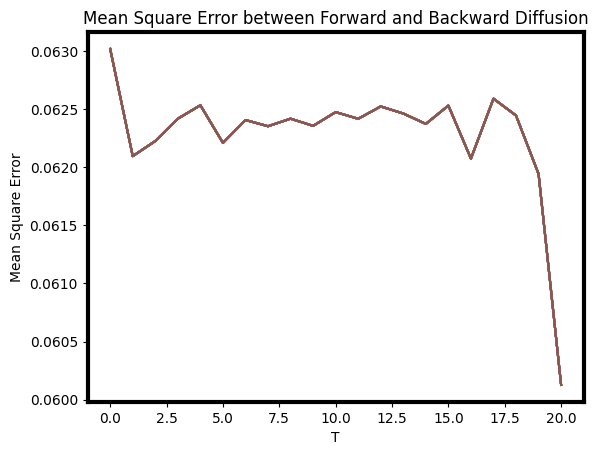

In [52]:
#calculate mean square error
#Xout[T][Ndata][2**n]
#backwards_gen[T][Ndata][2**n]
mse_calc = np.zeros((21, 16))
avg_backwards_vector = np.sum(backwards_gen, axis = 1)/Ndata
print(avg_backwards_vector)

orig_vals = np.sum((np.load('training_data.npy')), axis = 0) / 2000
#print(orig_vals)
for i in range(0, 21):
    temp1 = 0
    for j in range(0, 2**n):
        temp1 += (np.abs(orig_vals[j] - avg_backwards_vector[i][j]))**2
    print(temp1)
    mse_calc[i] = temp1/ 16

#mse_calc = np.abs(np.sum(mse_calc, axis = 1)) / 16

plt.plot(range(0, 21), mse_calc)
plt.title("Mean Square Error between Forward and Backward Diffusion")
plt.ylabel("Mean Square Error")
plt.xlabel("T")

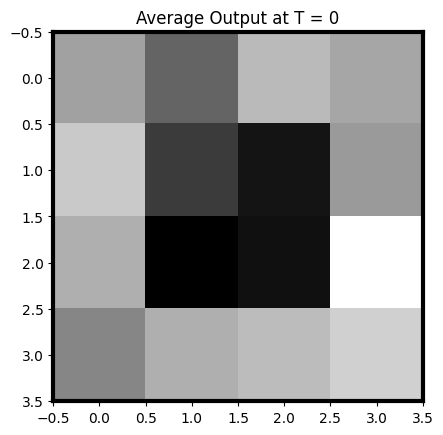

In [51]:
#visualize final_output_nxn for each data
#final_output_nxn[T][Ndata][4][4]
#print_this_1 is average output of model
#fig, axs = plt.subplots(1, 1, figsize = (10, 20))
num1 = np.max(np.abs(avg_backwards_vector))
print_this = np.abs(avg_backwards_vector) /num1
print_this_1 = np.zeros((4,4))
for i in range(0, 4):
    for j in range(0, 4):
        print_this_1[i][j] = print_this[0][4*i + j]


for z in range(0, 1):
    #print(final_output_nxn[z])
    plt.imshow(
        #final_output_nxn[0][z]
        print_this_1, cmap = 'grey', interpolation = 'nearest')
    plt.title('Average Output at T = %d'%0)

#plt.suptitle('Backwards Diffusion At T = 0')
#plt.tight_layout()
plt.show()